## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

## Load the Dataset

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Ganti dengan path ke folder dataset Anda di Google Drive
dataset_path = '/content/drive/My Drive/Datasets/TESS Toronto emotional speech set data'

paths = []
labels = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset is Loaded


In [ ]:
len(paths)

2801

In [ ]:
paths[:5]

['/content/drive/My Drive/Datasets/TESS Toronto emotional speech set data/YAF_disgust/YAF_bite_disgust.wav',
 '/content/drive/My Drive/Datasets/TESS Toronto emotional speech set data/YAF_disgust/YAF_bath_disgust.wav',
 '/content/drive/My Drive/Datasets/TESS Toronto emotional speech set data/YAF_disgust/YAF_gin_disgust.wav',
 '/content/drive/My Drive/Datasets/TESS Toronto emotional speech set data/YAF_disgust/YAF_goose_disgust.wav',
 '/content/drive/My Drive/Datasets/TESS Toronto emotional speech set data/YAF_disgust/YAF_calm_disgust.wav']

In [ ]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [ ]:
## Create a dataframe
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df.head()

,audio_paths,labels
0,/content/drive/My Drive/Datasets/TESS Toronto ...,disgust
1,/content/drive/My Drive/Datasets/TESS Toronto ...,disgust
2,/content/drive/My Drive/Datasets/TESS Toronto ...,disgust
3,/content/drive/My Drive/Datasets/TESS Toronto ...,disgust
4,/content/drive/My Drive/Datasets/TESS Toronto ...,disgust


In [ ]:
df['labels'].value_counts()

,count
labels,
disgust,400
fear,400
ps,400
angry,400
neutral,400
happy,400
sad,400
neutral (1),1


## Exploratory Data Analysis

<Axes: xlabel='labels', ylabel='count'>

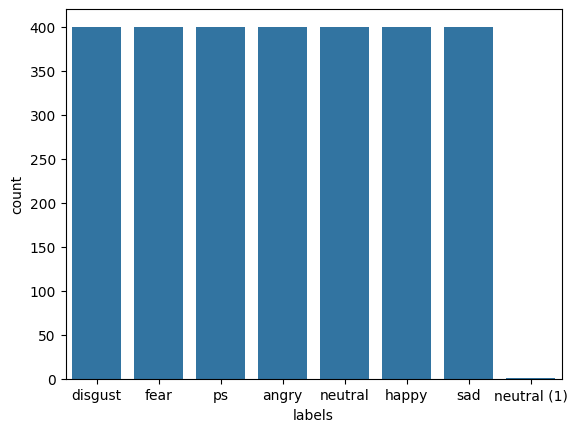

In [ ]:
sns.countplot(data=df, x='labels')

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

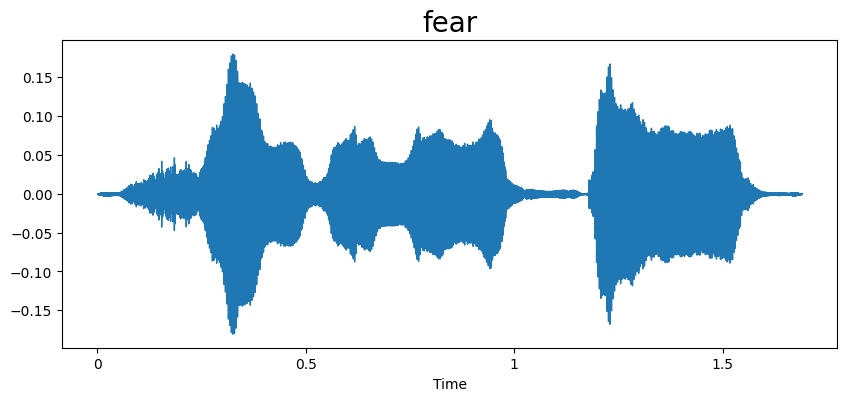

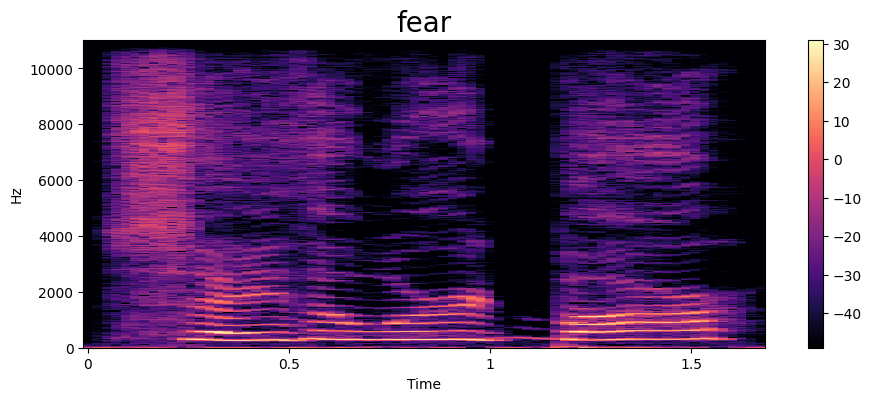

In [ ]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

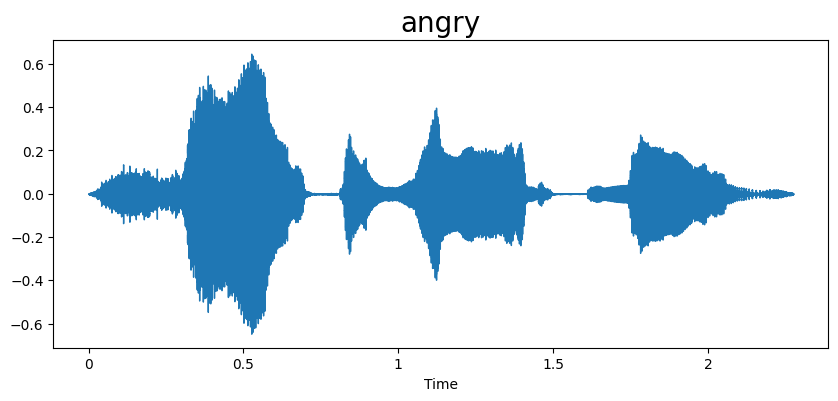

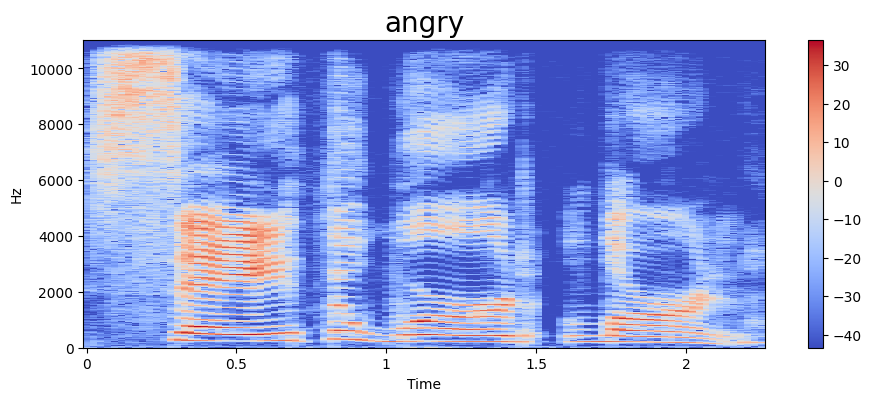

In [ ]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

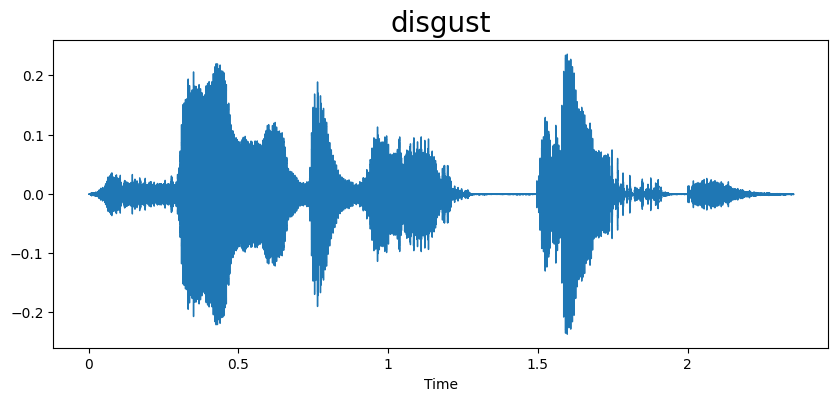

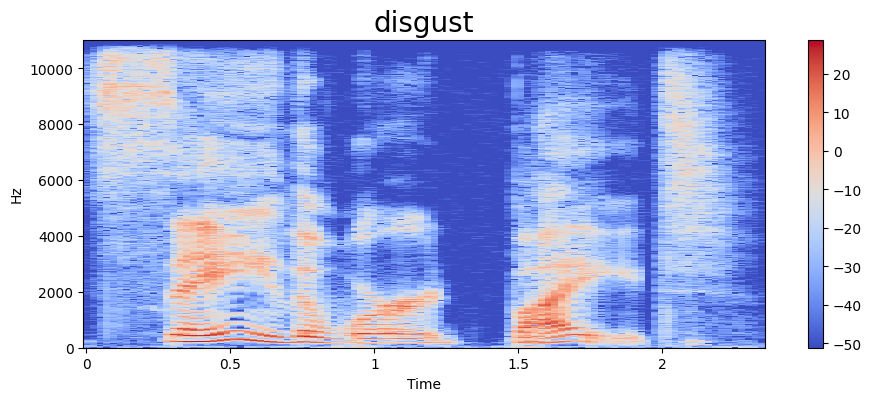

In [ ]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

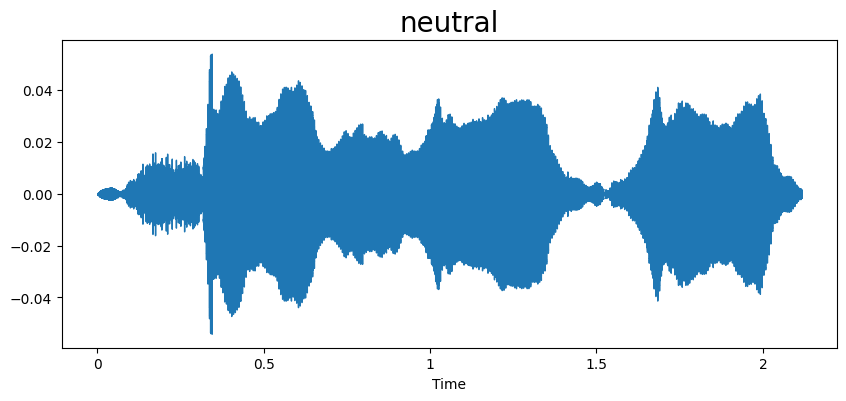

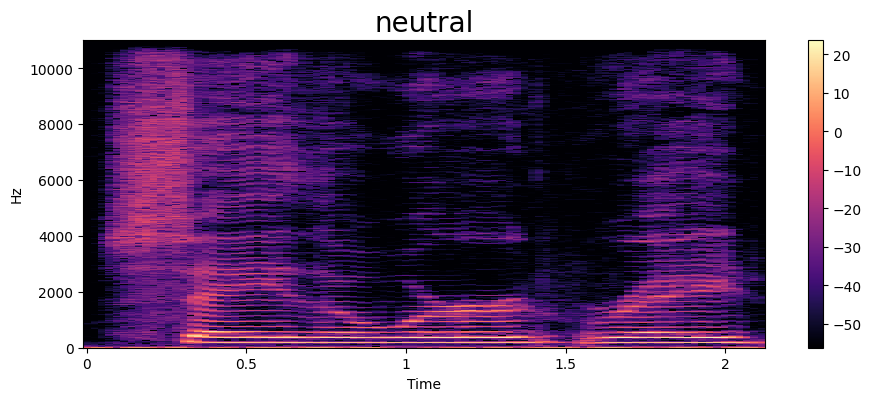

In [ ]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

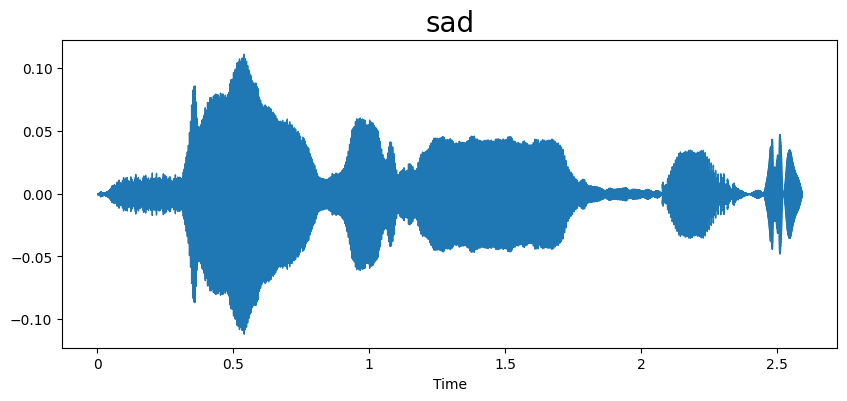

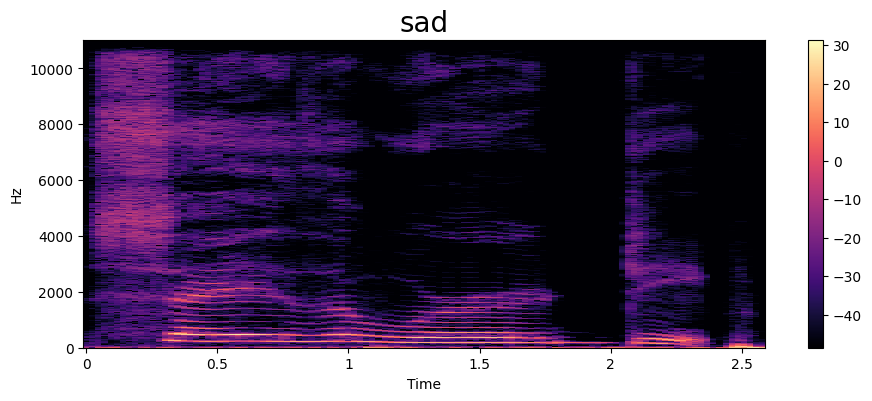

In [ ]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

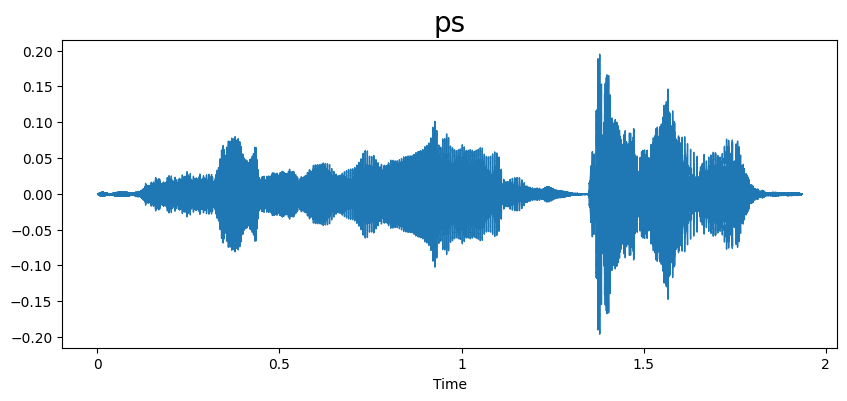

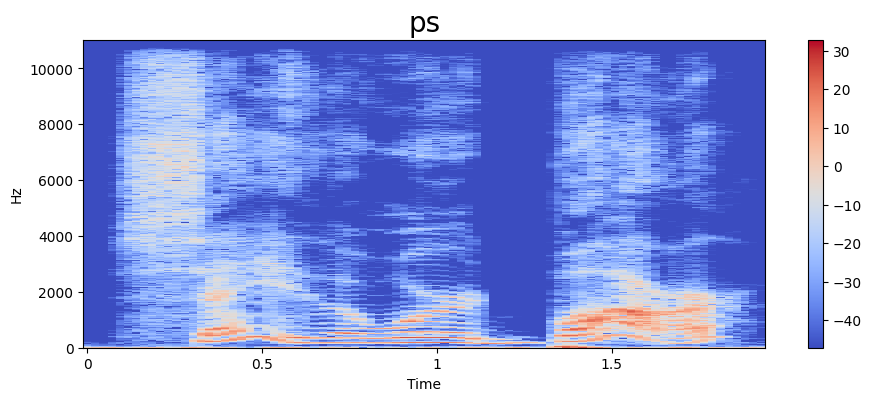

In [ ]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

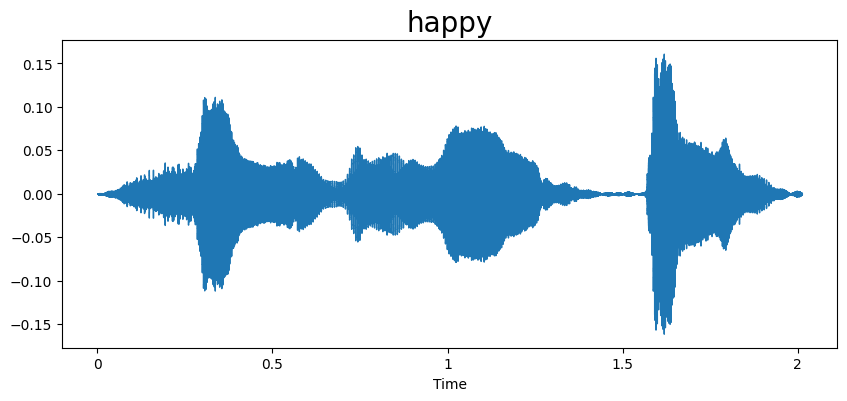

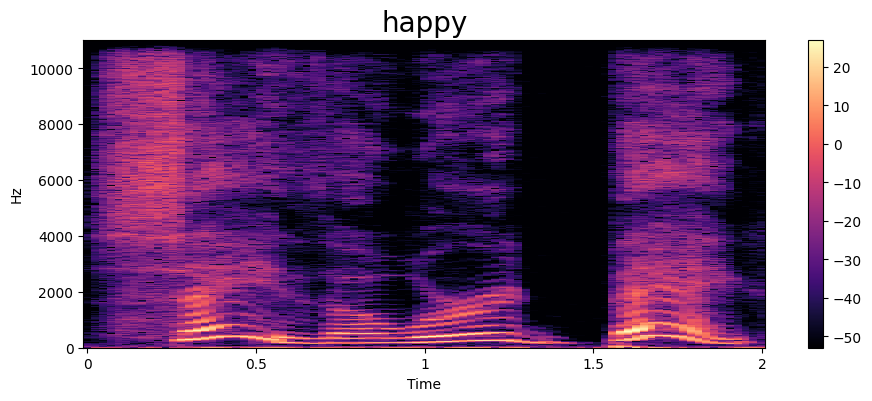

In [ ]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Create Custom Dataset Class

In [ ]:
# convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)

In [ ]:
class SpeechEmotionDataset(Dataset):
  def __init__(self, df, processor, max_length=32000):
    self.df = df
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    audio_path = self.df.iloc[idx]['audio_paths']
    label = self.df.iloc[idx]['labels']

    # load the audio file
    speech, sr = librosa.load(audio_path, sr=16000)

    # pad or truncate the speech to the required length
    if len(speech) > self.max_length:
      speech = speech[:self.max_length]
    else:
      speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

    # preprocess the audio file
    inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)
    input_values = inputs.input_values.squeeze()
    return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [ ]:
# split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    'facebook/wav2vec2-base',
    num_labels=len(label_map)  # Set the correct number of labels
)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [ ]:
train_dataset[0]['input_values'].size()

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


torch.Size([32000])

In [ ]:
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

## Create Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 4,
    weight_decay = 0.01,
    report_to = []
)

In [ ]:
# create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
  labels = pred.label_ids # original labels
  preds = np.argmax(pred.predictions, axis=1) # model predicted labels
  accuracy = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  return{
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1
  }

In [ ]:
# initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Mulai pelatihan
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.069313,0.998217,0.996456,0.998217,0.997332
2,No log,0.042077,0.998217,0.996456,0.998217,0.997332
3,No log,0.033238,0.998217,0.996456,0.998217,0.997332
4,0.066700,0.030895,0.998217,0.996456,0.998217,0.997332


TrainOutput(global_step=560, training_loss=0.06230181945221765, metrics={'train_runtime': 468.2777, 'train_samples_per_second': 19.134, 'train_steps_per_second': 1.196, 'total_flos': 1.6269174964224e+17, 'train_loss': 0.06230181945221765, 'epoch': 4.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.03089476004242897, 'eval_accuracy': 0.9982174688057041, 'eval_precision': 0.9964561582208642, 'eval_recall': 0.9982174688057041, 'eval_f1': 0.9973315401282996, 'eval_runtime': 7.4788, 'eval_samples_per_second': 75.012, 'eval_steps_per_second': 4.814, 'epoch': 4.0}


## Test Prediction

In [ ]:
import random

# Pilih indeks acak dari dataset tes
idx = random.randrange(0, len(test_dataset))

# Tampilkan label asli
print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

# Preproses data
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

# Lakukan prediksi
with torch.no_grad():
    outputs = model(input_values)

# Ambil hasil prediksi
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

# Tampilkan hasil prediksi
print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: sad
Predicted Label: sad


In [ ]:
import random

# Pilih indeks acak dari dataset tes
idx = random.randrange(0, len(test_dataset))

# Tampilkan label asli
print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

# Preproses data
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

# Lakukan prediksi
with torch.no_grad():
    outputs = model(input_values)

# Ambil hasil prediksi
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

# Tampilkan hasil prediksi
print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: ps
Predicted Label: ps


In [ ]:
import random

# Pilih indeks acak dari dataset tes
idx = random.randrange(0, len(test_dataset))

# Tampilkan label asli
print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

# Preproses data
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

# Lakukan prediksi
with torch.no_grad():
    outputs = model(input_values)

# Ambil hasil prediksi
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

# Tampilkan hasil prediksi
print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: angry
Predicted Label: angry
